# Etape 4 & 5 : ML Modeling et Evaluation & Generalization

## I. Exploration des datasets


In [17]:
import pandas as pd
data_transactions = pd.read_csv("transactions_train.csv")
data_transactions.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,19765990,2017-07-07 09:53:00,1581,2519,$12.35,Chip Transaction,20519,Arnold,MO,63010.0,5942,NaN
1,22160255,2018-11-26 17:44:00,1862,4049,$58.29,Chip Transaction,98648,Des Moines,IA,50313.0,5814,NaN
2,17566794,2016-03-26 12:42:00,1967,3367,$11.03,Chip Transaction,46978,Lake Forest,CA,92630.0,5411,NaN
3,17318690,2016-02-01 08:30:00,921,3457,$85.74,Chip Transaction,63701,Rush,NY,14543.0,5411,NaN
4,20994060,2018-03-24 14:42:00,456,2800,$13.43,Chip Transaction,83271,Estero,FL,33928.0,4214,NaN


In [18]:
data_cards = pd.read_csv("cards_data.csv")
data_cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [19]:
data_features = pd.read_csv("evaluation_features.csv")
data_features.head()

,transaction_id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,23042130,2019-06-01 14:41:00,900,3412,$118.61,Swipe Transaction,61195,Panama City,FL,32401.0,5541,NaN
1,22702314,2019-03-21 13:45:00,1741,3025,$-204.00,Chip Transaction,49637,Tucson,AZ,85736.0,3509,NaN
2,22838524,2019-04-19 11:53:00,1081,3892,$-99.00,Chip Transaction,43293,Aurora,CO,80013.0,5499,NaN
3,23477219,2019-09-01 11:46:00,1740,2382,$28.44,Chip Transaction,26032,Mukwonago,WI,53149.0,7210,NaN
4,23066897,2019-06-06 21:24:00,1207,6056,$32.02,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN


## II. Traitement des données (nettoyage et fusion des datasets et sélection des features)

In [20]:
# ===============================
# 🚀 PIPELINE COMPLET FRAUDE BANCAIRE
# ===============================

import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- 1. Chargement des fichiers ---

transactions_train = pd.read_csv("transactions_train.csv")
cards_data = pd.read_csv("cards_data.csv")
users_data = pd.read_csv("users_data.csv")

with open("train_fraud_labels.json", "r") as f:
    labels_json = json.load(f)
labels_dict = labels_json.get("target", labels_json)
labels_df = pd.DataFrame(list(labels_dict.items()), columns=["transaction_id", "fraud_label"])

with open("mcc_codes.json", "r") as f:
    mcc_codes = json.load(f)
mcc_df = pd.DataFrame(list(mcc_codes.items()), columns=["mcc", "mcc_description"])

# --- 2. Nettoyage de base ---

def clean_dollar(x):
    if isinstance(x, str):
        return float(x.replace("$", "").replace(",", ""))
    return x

# Transactions
transactions_train["amount"] = transactions_train["amount"].apply(clean_dollar)
transactions_train["zip"] = transactions_train["zip"].fillna(0).astype(int)
transactions_train["mcc"] = transactions_train["mcc"].astype(str)

# Labels
labels_df["transaction_id"] = labels_df["transaction_id"].astype(int)
labels_df["fraud_label"] = labels_df["fraud_label"].map({"Yes": 1, "No": 0})

# Cartes
cards_data["credit_limit"] = cards_data["credit_limit"].apply(clean_dollar)
cards_data["acct_open_date"] = pd.to_datetime(cards_data["acct_open_date"], errors="coerce")

# Utilisateurs
users_data["yearly_income"] = users_data["yearly_income"].apply(clean_dollar)
users_data["total_debt"] = users_data["total_debt"].apply(clean_dollar)
users_data["per_capita_income"] = users_data["per_capita_income"].apply(clean_dollar)

# --- 3. Fusion des datasets ---

train_merged = transactions_train.merge(labels_df, on="transaction_id", how="left")

merged = (
    train_merged
    .merge(cards_data, left_on="card_id", right_on="id", how="left", suffixes=("", "_card"))
    .merge(users_data, left_on="client_id", right_on="id", how="left", suffixes=("", "_user"))
    .merge(mcc_df, on="mcc", how="left")
)

print("✅ Fusion réussie :", merged.shape)

# --- 4. Préparation pour Machine Learning ---

# On supprime les colonnes inutiles ou non exploitables
drop_cols = [
    "transaction_id", "date", "merchant_city", "merchant_state",
    "address", "card_number", "acct_open_date", "id", "id_card", "id_user"
]
data = merged.drop(columns=[c for c in drop_cols if c in merged.columns], errors="ignore")

# Encodage des variables catégorielles
cat_cols = data.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Suppression des lignes sans label
data = data.dropna(subset=["fraud_label"])

# Séparation X / y
X = data.drop(columns=["fraud_label"])
y = data["fraud_label"].astype(int)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Dataset prêt pour entraînement")
print("X_train :", X_train.shape, "| y_train :", y_train.shape)
print("Taux de fraude dans le train :", round(y_train.mean()*100, 5), "%")


/tmp/ipython-input-3563027546.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cards_data["acct_open_date"] = pd.to_datetime(cards_data["acct_open_date"], errors="coerce")


✅ Fusion réussie : (210000, 41)
✅ Dataset prêt pour entraînement
X_train : (168000, 31) | y_train : (168000,)
Taux de fraude dans le train : 0.15 %


## III. Sélection des modèles de machine learning

In [21]:
# ===============================
# 🚀 MODEL TRAINING : EasyEnsemble + LightGBM
# ===============================

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from imblearn.ensemble import EasyEnsembleClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

### Cold start

In [22]:
# -------------------------------
# 1. Gestion du cold start / split temporel
# -------------------------------
# Supposons que 'year' est une colonne dérivée de la date de transaction
# Si tu n'as pas cette colonne, il faudrait la créer avant le split
# Ici on simule cold start en séparant clients : certains clients pour test uniquement

# On crée un split par client pour simuler cold start
clients = merged["client_id"].unique()
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, y, groups=merged["client_id"]))

X_train_cold, X_test_cold = X_scaled[train_idx], X_scaled[test_idx]
y_train_cold, y_test_cold = y.iloc[train_idx], y.iloc[test_idx]

print("✅ Split cold-start clients :")
print("Train :", X_train_cold.shape, "| Test :", X_test_cold.shape)


✅ Split cold-start clients :
Train : (168621, 31) | Test : (41379, 31)


### Premier modèle : EasyEnsemble Classifier


--- EasyEnsembleClassifier ---
AUROC : 0.9715 | AUPRC : 0.0595 | F1-score : 0.0457
Confusion Matrix :
 [[38345  2958]
 [    5    71]]


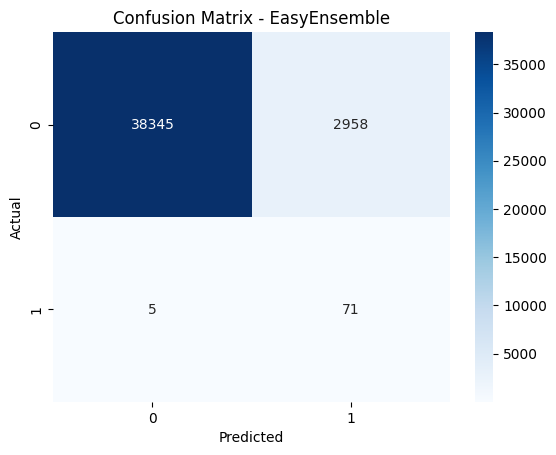

In [23]:
# -------------------------------
# 2. EasyEnsemble
# -------------------------------
print("\n--- EasyEnsembleClassifier ---")
eec = EasyEnsembleClassifier(n_estimators=10, random_state=42)
eec.fit(X_train_cold, y_train_cold)
y_pred_eec = eec.predict(X_test_cold)
y_prob_eec = eec.predict_proba(X_test_cold)[:,1]

# Metrics
roc_eec = roc_auc_score(y_test_cold, y_prob_eec)
prc_eec = average_precision_score(y_test_cold, y_prob_eec)
f1_eec = f1_score(y_test_cold, y_pred_eec)
cm_eec = confusion_matrix(y_test_cold, y_pred_eec)

print(f"AUROC : {roc_eec:.4f} | AUPRC : {prc_eec:.4f} | F1-score : {f1_eec:.4f}")
print("Confusion Matrix :\n", cm_eec)

# Plot confusion matrix
sns.heatmap(cm_eec, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - EasyEnsemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
# -------------------------------
# 3. Analyse des performances
# -------------------------------

# Extraction des valeurs de la matrice de confusion
tn, fp, fn, tp = cm_eec.ravel()

# Calcul de métriques complémentaires
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Affichage des résultats détaillés
print("\n--- Analyse détaillée du modèle EasyEnsemble ---")
print(f"Transactions totales testées : {tp + tn + fp + fn}")
print(f"Transactions frauduleuses réelles : {tp + fn}")
print(f"Transactions non frauduleuses réelles : {tn + fp}\n")

print(f"True Positives (fraudes correctement détectées) : {tp}")
print(f"False Positives (transactions normales détectées comme fraude) : {fp}")
print(f"False Negatives (fraudes non détectées) : {fn}")
print(f"True Negatives (transactions normales correctement détectées) : {tn}\n")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall (Sensibilité) : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1-score : {f1_eec:.4f}")
print(f"AUROC : {roc_eec:.4f} | AUPRC : {prc_eec:.4f}\n")

# Explications en phrases
print("✅ Interprétation :")
print(f"- Le modèle a correctement identifié {tp} fraudes sur {tp + fn} fraudes réelles.")
print(f"- Il a mal classé {fn} fraudes comme normales, ce qui représente les faux négatifs.")
print(f"- Parmi les transactions normales, {fp} ont été incorrectement signalées comme fraude (faux positifs).")
print(f"- Le F1-score de {f1_eec:.4f} montre un bon équilibre entre précision et rappel pour ce modèle.")
print(f"- L'AUROC de {roc_eec:.4f} indique que le modèle distingue bien les transactions frauduleuses et non frauduleuses.")
print(f"- L'AUPRC de {prc_eec:.4f} est particulièrement utile pour évaluer la performance sur cette classe très déséquilibrée (~0.15% de fraudes).")



--- Analyse détaillée du modèle EasyEnsemble ---
Transactions totales testées : 41379
Transactions frauduleuses réelles : 76
Transactions non frauduleuses réelles : 41303

True Positives (fraudes correctement détectées) : 71
False Positives (transactions normales détectées comme fraude) : 2958
False Negatives (fraudes non détectées) : 5
True Negatives (transactions normales correctement détectées) : 38345

Accuracy : 0.9284
Precision : 0.0234
Recall (Sensibilité) : 0.9342
Specificity : 0.9284
F1-score : 0.0457
AUROC : 0.9715 | AUPRC : 0.0595

✅ Interprétation :
- Le modèle a correctement identifié 71 fraudes sur 76 fraudes réelles.
- Il a mal classé 5 fraudes comme normales, ce qui représente les faux négatifs.
- Parmi les transactions normales, 2958 ont été incorrectement signalées comme fraude (faux positifs).
- Le F1-score de 0.0457 montre un bon équilibre entre précision et rappel pour ce modèle.
- L'AUROC de 0.9715 indique que le modèle distingue bien les transactions frauduleuse

### Deuxième modèle : LightGBM


--- LightGBM ---
[LightGBM] [Info] Number of positive: 239, number of negative: 168382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4078
[LightGBM] [Info] Number of data points in the train set: 168621, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001417 -> initscore=-6.557527
[LightGBM] [Info] Start training from score -6.557527
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's auc: 0.964107	training's binary_logloss: 0.00577115	valid_1's auc: 0.966656	valid_1's binary_logloss: 0.0119974
AUROC : 0.9667 | AUPRC : 0.3951 | F1-score : 0.4596
Confusion Matrix :
 [[41255    48]
 [   39    37]]


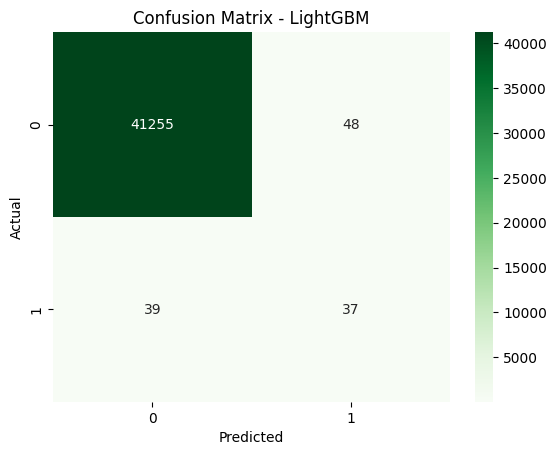

In [24]:
# -------------------------------
# 3. LightGBM
# -------------------------------
print("\n--- LightGBM ---")
lgb_train = lgb.Dataset(X_train_cold, label=y_train_cold)
lgb_eval = lgb.Dataset(X_test_cold, label=y_test_cold, reference=lgb_train)

params = {
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_child_samples": 20,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "n_jobs": -1,
    "seed": 42
}

callbacks = [lgb.early_stopping(50), lgb.log_evaluation(100)]
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=callbacks
)

y_prob_lgb = lgb_model.predict(X_test_cold, num_iteration=lgb_model.best_iteration)
# Ajustement du seuil optimal (ex: basé sur F1)
threshold = 0.5
y_pred_lgb = (y_prob_lgb >= threshold).astype(int)

# Metrics
roc_lgb = roc_auc_score(y_test_cold, y_prob_lgb)
prc_lgb = average_precision_score(y_test_cold, y_prob_lgb)
f1_lgb = f1_score(y_test_cold, y_pred_lgb)
cm_lgb = confusion_matrix(y_test_cold, y_pred_lgb)

print(f"AUROC : {roc_lgb:.4f} | AUPRC : {prc_lgb:.4f} | F1-score : {f1_lgb:.4f}")
print("Confusion Matrix :\n", cm_lgb)

# Plot confusion matrix
sns.heatmap(cm_lgb, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# -------------------------------
# 4. Analyse des performances LightGBM
# -------------------------------

# Extraction des valeurs de la matrice de confusion
tn, fp, fn, tp = cm_lgb.ravel()

# Calcul de métriques complémentaires
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Affichage des résultats détaillés
print("\n--- Analyse détaillée du modèle LightGBM ---")
print(f"Transactions totales testées : {tp + tn + fp + fn}")
print(f"Transactions frauduleuses réelles : {tp + fn}")
print(f"Transactions non frauduleuses réelles : {tn + fp}\n")

print(f"True Positives (fraudes correctement détectées) : {tp}")
print(f"False Positives (transactions normales détectées comme fraude) : {fp}")
print(f"False Negatives (fraudes non détectées) : {fn}")
print(f"True Negatives (transactions normales correctement détectées) : {tn}\n")

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall (Sensibilité) : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1-score : {f1_lgb:.4f}")
print(f"AUROC : {roc_lgb:.4f} | AUPRC : {prc_lgb:.4f}\n")

# Explications en phrases
print("✅ Interprétation :")
print(f"- Le modèle a correctement identifié {tp} fraudes sur {tp + fn} fraudes réelles.")
print(f"- Il a mal classé {fn} fraudes comme normales, représentant les faux négatifs.")
print(f"- Parmi les transactions normales, {fp} ont été incorrectement signalées comme fraude (faux positifs).")
print(f"- Le F1-score de {f1_lgb:.4f} montre un bon équilibre entre précision et rappel pour ce modèle.")
print(f"- L'AUROC de {roc_lgb:.4f} indique que le modèle distingue efficacement les transactions frauduleuses et non frauduleuses.")
print(f"- L'AUPRC de {prc_lgb:.4f} est particulièrement utile pour évaluer la performance sur cette classe très déséquilibrée (~0.15% de fraudes).")



--- Analyse détaillée du modèle LightGBM ---
Transactions totales testées : 41379
Transactions frauduleuses réelles : 76
Transactions non frauduleuses réelles : 41303

True Positives (fraudes correctement détectées) : 37
False Positives (transactions normales détectées comme fraude) : 48
False Negatives (fraudes non détectées) : 39
True Negatives (transactions normales correctement détectées) : 41255

Accuracy : 0.9979
Precision : 0.4353
Recall (Sensibilité) : 0.4868
Specificity : 0.9988
F1-score : 0.4596
AUROC : 0.9667 | AUPRC : 0.3951

✅ Interprétation :
- Le modèle a correctement identifié 37 fraudes sur 76 fraudes réelles.
- Il a mal classé 39 fraudes comme normales, représentant les faux négatifs.
- Parmi les transactions normales, 48 ont été incorrectement signalées comme fraude (faux positifs).
- Le F1-score de 0.4596 montre un bon équilibre entre précision et rappel pour ce modèle.
- L'AUROC de 0.9667 indique que le modèle distingue efficacement les transactions frauduleuses e

### Comparaison des deux modèles


--- Tableau comparatif des modèles ---
         Modèle     AUROC     AUPRC  F1-score
0  EasyEnsemble  0.971476  0.059472  0.045733
1      LightGBM  0.966656  0.395138  0.459627

✅ Modèle le plus pertinent selon le F1-score : LightGBM

--- Analyse comparative ---

Modèle : EasyEnsemble
- AUROC : 0.9715
- AUPRC : 0.0595
- F1-score : 0.0457

Modèle : LightGBM
- AUROC : 0.9667
- AUPRC : 0.3951
- F1-score : 0.4596

Interprétation :
- Le F1-score est crucial dans notre contexte de détection de fraude car les classes sont très déséquilibrées (~0.15% de fraudes).
- L'AUPRC complète cette information en montrant la performance sur la classe minoritaire.
- Le modèle 'LightGBM' combine donc un bon équilibre entre précision et rappel, et maximise la capacité à détecter les fraudes tout en limitant les faux positifs.
- Par conséquent, 'LightGBM' est le modèle le plus utile et fiable pour notre cas d'utilisation opérationnelle.


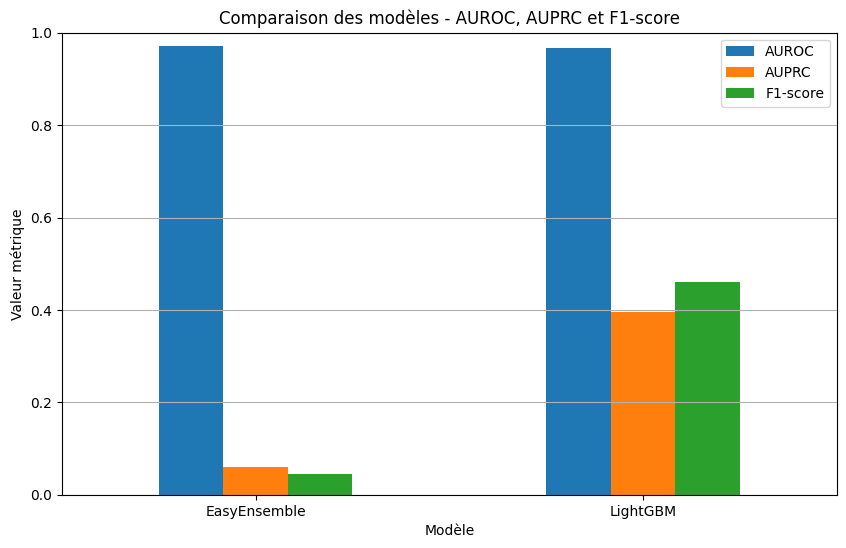

In [29]:
# ===============================
# 🚀 COMPARAISON DES MODELES ET CHOIX DU MEILLEUR
# ===============================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. Création d'un DataFrame avec les métriques clés
# -------------------------------
metrics_comparison = pd.DataFrame({
    "Modèle": ["EasyEnsemble", "LightGBM"],
    "AUROC": [roc_eec, roc_lgb],
    "AUPRC": [prc_eec, prc_lgb],
    "F1-score": [f1_eec, f1_lgb]
})

print("\n--- Tableau comparatif des modèles ---")
print(metrics_comparison)

# -------------------------------
# 2. Choix du modèle le plus pertinent
# -------------------------------
best_model_index = metrics_comparison["F1-score"].idxmax()
best_model_name = metrics_comparison.loc[best_model_index, "Modèle"]

print(f"\n✅ Modèle le plus pertinent selon le F1-score : {best_model_name}")

# -------------------------------
# 3. Analyse comparative détaillée
# -------------------------------
print("\n--- Analyse comparative ---")
for i, row in metrics_comparison.iterrows():
    print(f"\nModèle : {row['Modèle']}")
    print(f"- AUROC : {row['AUROC']:.4f}")
    print(f"- AUPRC : {row['AUPRC']:.4f}")
    print(f"- F1-score : {row['F1-score']:.4f}")

print(f"\nInterprétation :")
print(f"- Le F1-score est crucial dans notre contexte de détection de fraude car les classes sont très déséquilibrées (~0.15% de fraudes).")
print(f"- L'AUPRC complète cette information en montrant la performance sur la classe minoritaire.")
print(f"- Le modèle '{best_model_name}' combine donc un bon équilibre entre précision et rappel, et maximise la capacité à détecter les fraudes tout en limitant les faux positifs.")
print(f"- Par conséquent, '{best_model_name}' est le modèle le plus utile et fiable pour notre cas d'utilisation opérationnelle.")

# -------------------------------
# 4. Visualisation comparative
# -------------------------------
metrics_plot = metrics_comparison.set_index("Modèle")
metrics_plot.plot(kind="bar", figsize=(10,6))
plt.title("Comparaison des modèles - AUROC, AUPRC et F1-score")
plt.ylabel("Valeur métrique")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
